# Kalman Filters

In this lab you will:

- Estimate Moving Average
- Use Kalman Filters to calculate the mean and covariance of our time series
- Modify a Pairs trading function to make use of Kalman Filters

## What is a Kalman Filter?

The Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

The algorithm is as follows:
1. Take as input a mathematical model of the system, i.e.
  * the transition matrix, which tells us how the system evolves from one state to another. For instance, if we are modeling the movement of a car, then the next values of position and velocity can be computed from the previous ones using kinematic equations. Alternatively, if we have a system which is fairly stable, we might model its evolution as a random walk. If you want to read up on Kalman filters, note that this matrix is usually called $A$.
  * the observation matrix, which tells us the next measurement we should expect given the predicted next state. If we are measuring the position of the car, we just extract the position values stored in the state. For a more complex example, consider estimating a linear regression model for the data. Then our state is the coefficients of the model, and we can predict the next measurement from the linear equation. This is denoted $H$.
  * any control factors that affect the state transitions but are not part of the measurements. For instance, if our car were falling, gravity would be a control factor. If the noise does not have mean 0, it should be shifted over and the offset put into the control factors. The control factors are summarized in a matrix $B$ with time-varying control vector $u_t$, which give the offset $Bu_t$.
  * covariance matrices of the transition noise (i.e. noise in the evolution of the system) and measurement noise, denoted $Q$ and $R$, respectively.
2. Take as input an initial estimate of the state of the system and the error of the estimate, $\mu_0$ and $\sigma_0$.
3. At each timestep:
  * estimate the current state of the system $x_t$ using the transition matrix
  * take as input new measurements $z_t$
  * use the conditional probability of the measurements given the state, taking into account the uncertainties of the measurement and the state estimate, to update the estimated current state of the system $x_t$ and the covariance matrix of the estimate $P_t$

[This graphic](https://upload.wikimedia.org/wikipedia/commons/a/a5/Basic_concept_of_Kalman_filtering.svg) illustrates the procedure followed by the algorithm. 

It's very important for the algorithm to keep track of the covariances of its estimates. This way, it can give us a more nuanced result than simply a point value when we ask for it, and it can use its confidence to decide how much to be influenced by new measurements during the update process. The more certain it is of its estimate of the state, the more skeptical it will be of measurements that disagree with the state.

By default, the errors are assumed to be normally distributed, and this assumption allows the algorithm to calculate precise confidence intervals. It can, however, be implemented for non-normal errors.

## Install dependencies

In [2]:
!pip install pykalman

  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48467 sha256=eb439440ddfe7d819c1856f114ffa146e03455977e9942656650ac9228cfb6fc
  Stored in directory: c:\users\alex\appdata\local\pip\cache\wheels\6a\04\02\2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [3]:
!pip install qq-training-wheels auquan_toolbox --upgrade

Requirement already up-to-date: qq-training-wheels in g:\anaconda\lib\site-packages (0.0.1)
Requirement already up-to-date: auquan_toolbox in c:\users\alex\appdata\roaming\python\python37\site-packages (2.1.92)


In [4]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime


# Toy example: falling ball

Imagine we have a falling ball whose motion we are tracking with a camera. The state of the ball consists of its position and velocity. We know that we have the relationship $x_t = x_{t-1} + v_{t-1}\tau - \frac{1}{2} g \tau^2$, where $\tau$ is the time (in seconds) elapsed between $t-1$ and $t$ and $g$ is gravitational acceleration. Meanwhile, our camera can tell us the position of the ball every second, but we know from the manufacturer that the camera accuracy, translated into the position of the ball, implies variance in the position estimate of about 3 meters.

In order to use a Kalman filter, we need to give it transition and observation matrices, transition and observation covariance matrices, and the initial state. The state of the system is (position, velocity), so it follows the transition matrix
$$ \left( \begin{array}{cc}
1 & \tau \\
0 & 1 \end{array} \right) $$

with offset $(-\tau^2 \cdot g/2, -\tau\cdot g)$. The observation matrix just extracts the position coordinate, (1  0), since we are measuring position. We know that the observation variance is 1, and transition covariance is 0 since we will be simulating the data the same way we specified our model. For the initial state, let's feed our model something bogus like (30, 10) and see how our system evolves.

In [5]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [6]:
# Create a simulation of a ball falling for 40 units of time (each of length tau)
times = np.arange(40)
actual = -4.9*tau**2*times**2

# Simulate the noisy camera data
sim = actual + 3*np.random.randn(40)

# Run filter on camera data
state_means, state_covs = kf.filter(sim)

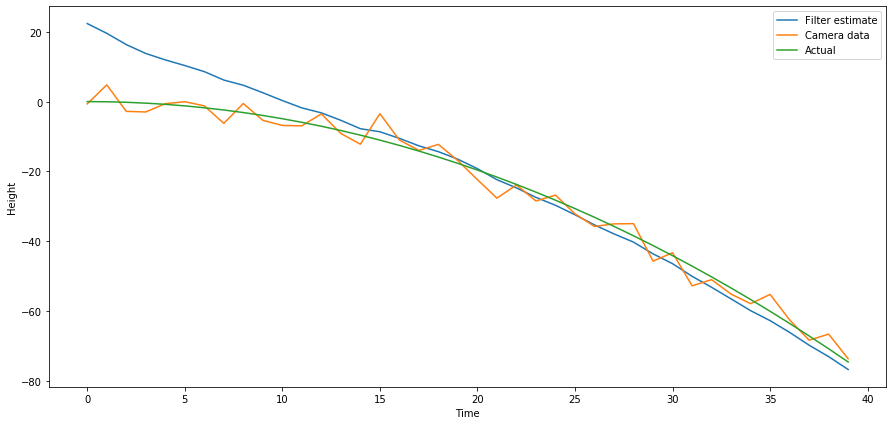

In [7]:
plt.figure(figsize=(15,7))
plt.plot(times, state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

At each point in time we plot the state estimate <i>after</i> accounting for the most recent measurement, which is why we are not at position 30 at time 0. The filter's attentiveness to the measurements allows it to correct for the initial bogus state we gave it. Then, by weighing its model and knowledge of the physical laws against new measurements, it is able to filter out much of the noise in the camera data. Meanwhile the confidence in the estimate increases with time, as shown by the graph below:

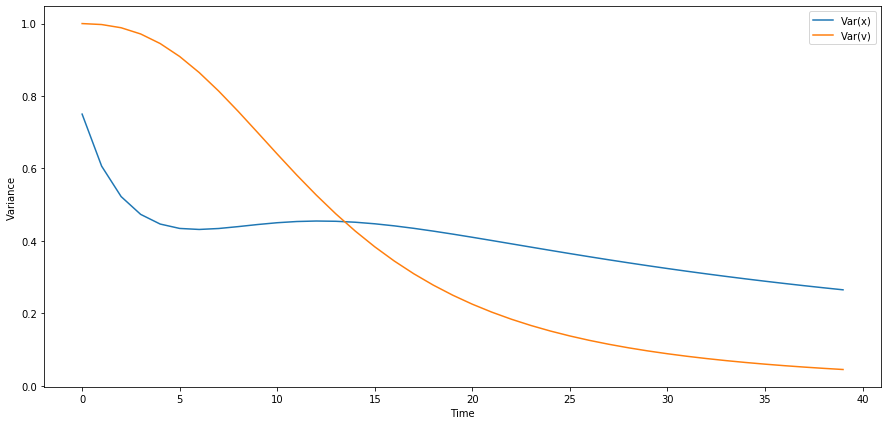

In [8]:
# Plot variances of x and v, extracting the appropriate values from the covariance matrix
plt.figure(figsize=(15,7))
plt.plot(times, state_covs[:,0,0])
plt.plot(times, state_covs[:,1,1])
plt.legend(['Var(x)', 'Var(v)'])
plt.ylabel('Variance')
plt.xlabel('Time');

The Kalman filter can also do <i>smoothing</i>, which takes in all of the input data at once and then constructs its best guess for the state of the system in each period post factum. That is, it does not provide online, running estimates, but instead uses all of the data to estimate the historical state, which is useful if we only want to use the data after we have collected all of it.

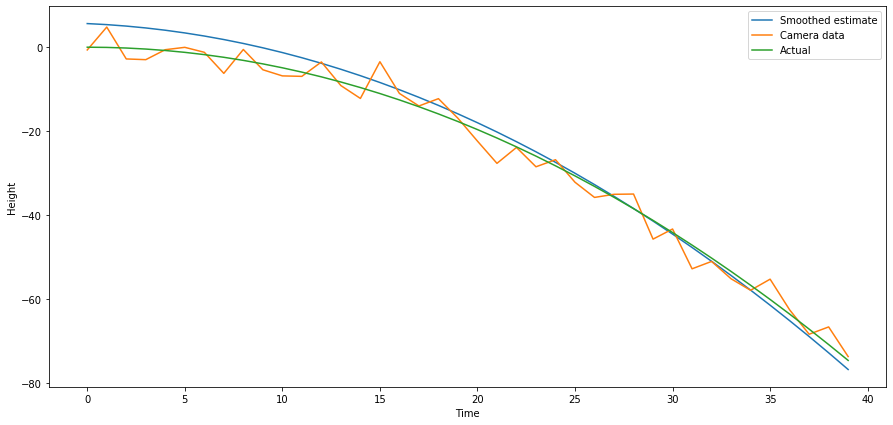

In [9]:
# Use smoothing to estimate what the state of the system has been
smoothed_state_means, _ = kf.smooth(sim)

# Plot results
plt.figure(figsize=(15,7))
plt.plot(times, smoothed_state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Smoothed estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

# Example: Estimating Moving Average

Because the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, it can be used to estimate rolling parameters of the data. When using a Kalman filter, there's no window length that we need to specify. This is useful for computing the moving average or for smoothing out estimates of other quantities.

Below, we'll use both a Kalman filter and an n-day moving average to estimate the rolling mean of a dataset. We construct the inputs to the Kalman filter as follows:

* The mean is the model's guess for the mean of the distribution from which measurements are drawn. This means our prediction of the next value is equal to our estimate of the mean. 
* Hopefully the mean describes our observations well, hence it shouldn't change significantly when we add an observation. This implies we can assume that it evolves as a random walk with a small error term. We set the transition matrix to 1 and transition covariance matrix is a small number.
* We assume that the observations have variance 1 around the rolling mean (1 is chosen randomly). 
* Our initial guess for the mean is 0, but the filter realizes that that is incorrect and adjusts.

Processing data for stock: SPY
Processing data for stock: MSFT
Processing data for stock: ADBE
20% done...
40% done...
60% done...
80% done...


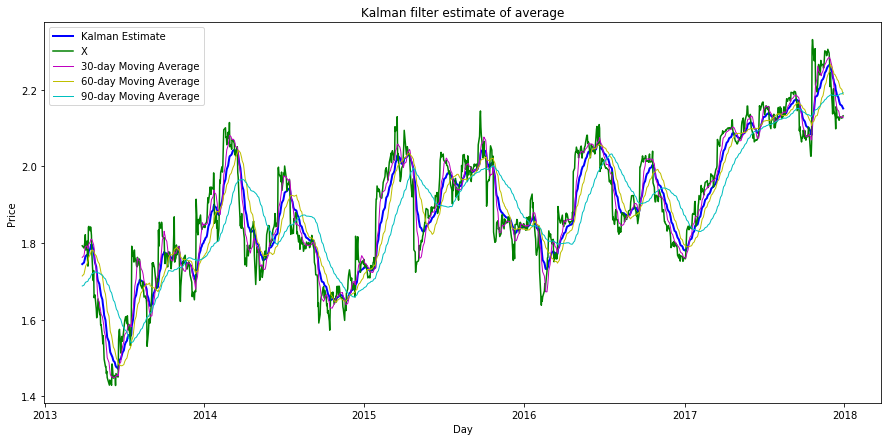

In [10]:
from pykalman import KalmanFilter
from backtester.dataSource.yahoo_data_source import YahooStockDataSource

# Load pricing data for a security
startDateStr = '2012/12/31'
endDateStr = '2017/12/31'
cachedFolderName = './yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','MSFT','ADBE']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')

# Get adjusted closing price
data = ds.getBookDataByFeature()['adjClose']

# Data for Adobe
S1 = data['ADBE']
# Data for Microsoft
S2 = data['MSFT']

# Take ratio of the adjusted closing prices
x = S1/S2

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 10).mean()
mean60 = x.rolling(window = 30).mean()
mean90 = x.rolling(window = 60).mean()

# Plot original data and estimated mean
plt.figure(figsize=(15,7))
plt.plot(state_means[60:], '-b', lw=2, )
plt.plot(x[60:],'-g',lw=1.5)
plt.plot(mean30[60:], 'm', lw=1)
plt.plot(mean60[60:], 'y', lw=1)
plt.plot(mean90[60:], 'c', lw=1)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

### Observations

As you can see, the estimate from Kalman Filter is usually somewhere between day 30 and day 60 moving average. This could be because the Filter updates its knowledge of the world based on the most recent data. The advantage of the Kalman filter is that we don't need to select a window length. It makes predictions based on the underlying model (that we set parameters for) and the data itself. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define. There's no free lunch and we can't eliminate overfitting, but a Kalman Filter is more rigorous than a moving average and generally better.

Another interesting application of Kalman Filters, Beta Estimation for Linear Regression can be found here [Dr. Aidan O'Mahony's blog.](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)


We'll be using Kalman filters for Pairs trading the subsequent notebook. Make sure you try to run the examples given here with various hyperparameters for the underlying Kalman filter model to get comfortable with the same and developing a better understanding in the process. For example you can try out the following:
1. Use multi dimensional transition matrices so as to use more of past information for making predictions at each point
2. Try different values of observation and transition covariance

## Example: Pairs Trading

In the previous notebook we made use of 60 day window for calculating mean and standard deviation of our time series. Now we'll be replacing that with Kalman filters

### Let's get the same data that we used in the previous notebook

In [11]:
startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading2'
instrumentIds = ['ADBE','MSFT']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: ADBE
Processing data for stock: MSFT
20% done...
40% done...
60% done...
80% done...


In [12]:
data

,ADBE,MSFT
2007-12-03,42.689999,24.662655
2007-12-04,43.320000,24.550285
2007-12-05,43.900002,25.584137
2007-12-06,44.540001,25.883808
2007-12-07,44.369999,25.868822
2007-12-10,44.619999,26.041136
2007-12-11,43.270000,25.546675
2007-12-12,43.540001,25.823877
2007-12-13,43.900002,26.385748
2007-12-14,42.110001,26.453175


### A quick visualization of error and standard deviations

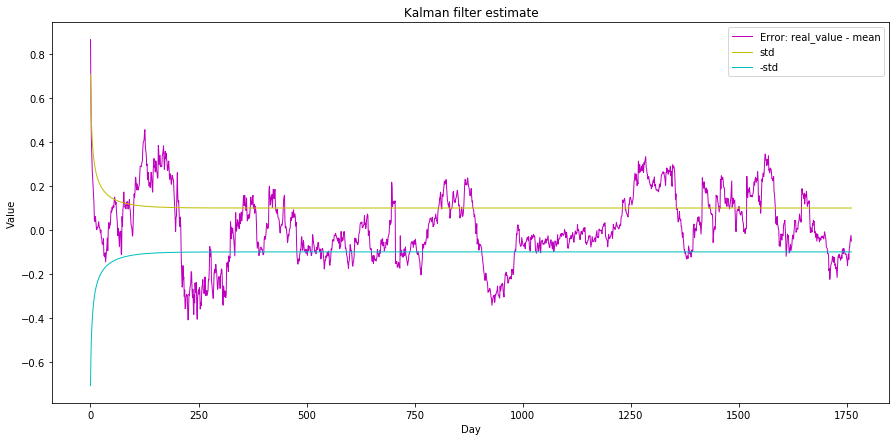

In [13]:
S1, S2 = data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762]
ratios = S1/S2

kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

state_means, state_cov = kf.filter(ratios.values)
state_means, state_std = state_means.squeeze(), np.std(state_cov.squeeze())

plt.figure(figsize=(15,7))
plt.plot(ratios.values - state_means, 'm', lw=1)
plt.plot(np.sqrt(state_cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(state_cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value');


We'll be using the z score in the same way as before. Our strategy is to go long or short only in the areas where the |error| is greater than one standard deviation. Since 1 day price could be noisy, we'll be using 5 day average for a particular day's price

#### Let's modify our trading function to make use of Kalman Filter while keeping the same logic for carrying out trades

In [14]:
def trade(S1, S2):
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.001)
    
    state_means, state_cov = kf.filter(ratios.values)
    state_means, state_std = state_means.squeeze(), np.std(state_cov.squeeze())
    
    window = 5
    ma = ratios.rolling(window=window,
                               center=False).mean()
    zscore = (ma - state_means)/state_std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


In [15]:
trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762])

1585.3315432190311

The strategy is still profitable! You can try changing the hyperparameters of the Kalman Filter and see how it affects the PnL. The results might not be always better than the mean over moving window. You can try this with other instruments as well.